<a href="https://colab.research.google.com/github/KicksxNPQ/CS114.K21.KHTN/blob/master/ML_Do_an.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ĐỀ TÀI: NHẬN DIỆN XE MÁY**

1. Mô tả bài toán
- Input: Một hình ảnh chiếc xe
- Output: Phân loại xe máy đó là xe số hay xe tay ga

2. Mô tả về bộ dữ liệu
- Cách thức xây dựng bộ dữ liệu: tìm kiếm trên mạng, thu thập hình ảnh từ bạn bè.
- Số lượng: 500 ảnh
- Độ đa dạng: chỉ tập trung về xe máy.
- Các thao tác tiền xử lý dữ liệu: 
> Thu thập dữ liệu
> Gắn nhãn dữ liệu

- Phân chia dữ liệu: 
> Train/Dev/Test: 8/1/1

3. Mô tả về đặc trưng
+ Số lượng bánh xe
+ Chiều dài xe
+ Chiều rộng bánh xe
+ Loại xe (tay ga, tay côn, xe số)

4. Mô tả về thuật toán máy học
- Sử dụng thuật toán Faster R-CNN

5. Cài đặt, tinh chỉnh tham số

6. Đánh giá kết quả, kết luận

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import os
import glob
import h5py
import shutil
import imgaug as aug
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import imgaug.augmenters as iaa
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import cv2
from keras import backend as K

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [4]:
print(os.listdir())

['.config', 'drive', 'sample_data']


In [5]:
data_dir = Path(r'./drive/My Drive/MotorCycle_data')
automotor_data = data_dir / 'AutomaticTransmissionMotorcycle'
manualmotor_data = data_dir / 'ManualTransmissionMotorcycle'
print(automotor_data)

drive/My Drive/MotorCycle_data/AutomaticTransmissionMotorcycle


In [6]:
def get_data(data, pattern):
  data_case = data.glob(pattern)
  return data_case

Gán nhãn:
+ Nhãn 0 là xe tay ga
+ Nhãn 1 là xe gắn máy

In [7]:
train_data = []
for img in get_data(automotor_data, '*.jpeg'):
  train_data.append((img,0))
for img in get_data(automotor_data, '*.jpg'):
  train_data.append((img,0))
for img in get_data(automotor_data, '*.png'):
  train_data.append((img,0))
for img in get_data(manualmotor_data, '*.jpeg'):
  train_data.append((img,1))
for img in get_data(manualmotor_data, '*.jpg'):
  train_data.append((img,1))
for img in get_data(manualmotor_data, '*.png'):
  train_data.append((img,1))
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)
train_data = train_data.sample(frac=1.).reset_index(drop=True)

In [8]:
train_data.head()

,image,label
0,drive/My Drive/MotorCycle_data/ManualTransmiss...,1
1,drive/My Drive/MotorCycle_data/ManualTransmiss...,1
2,drive/My Drive/MotorCycle_data/AutomaticTransm...,0
3,drive/My Drive/MotorCycle_data/ManualTransmiss...,1
4,drive/My Drive/MotorCycle_data/ManualTransmiss...,1


0    62
1    61
Name: label, dtype: int64


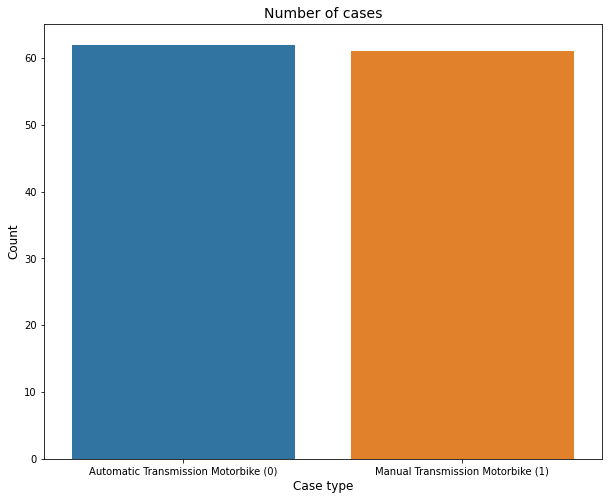

In [12]:
cases_count = train_data['label'].value_counts()
print(cases_count)

plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Automatic Transmission Motorbike (0)', 'Manual Transmission Motorbike (1)'])
plt.show()

In [31]:
data_gen_args = dict(featurewise_center=True,
                     featurewise_std_normalization=True,
                     rotation_range=90,
                     width_shift_range=[-200,-200],
                     height_shift_range=[-200,200],
                     horizontal_flip=True,
                     vertical_flip=True,
                     rescale=1./255,)
image_data = ImageDataGenerator(**data_gen_args)

image_data = image_data.flow_from_directory(
    directory=data_dir,
    target_size=(256, 256),
    color_mode="rgb",
    classes=['AutomaticTransmissionMotorcycle','ManualTransmissionMotorcycle'],
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=None,
    save_to_dir=None,
    save_prefix="",
    save_format="png",
    follow_links=False,
    subset=None,
    interpolation="bilinear"
)
for i in range(9):
	# define subplot
	plt.subplot(256 + 1 + i)
	# generate batch of images
	batch = image_data.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
  print(image)
	#plt.imshow((image[1],image[2],image[3]))
# show the figure
plt.show()

IndentationError: ignored